In [170]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [171]:
#lib for utilities
import warnings
from pathlib import Path

#lib for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

#lib for math
import numpy as np

#lib for data handling
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    titlepad=10
)

warnings.filterwarnings("ignore")

In [172]:
def load_data():
    # Read data
    data_path = Path("../input/titanic/")
    df_train = pd.read_csv(data_path / "train.csv", index_col="PassengerId")
    df_test = pd.read_csv(data_path / "test.csv", index_col="PassengerId")
    
    # Save indexes
    train_index = df_train.index
    test_index = df_test.index

    # Merge full dataset
    df_full = pd.concat([df_train, df_test])
    
    # Preprocess all the data
    df_full = clean(df_full)
    df_full = impute(df_full, train_index, test_index)
    df_full = encode(df_full, train_index, test_index)

    # Redistribute all the data
    df_train = df_full.loc[train_index]
    df_test = df_full.loc[test_index]

    # Return treated data
    return df_train, df_test

In [173]:
def load_data():
    # Read data
    data_path = Path("../input/titanic/")
    df_train = pd.read_csv(data_path / "train.csv", index_col="PassengerId")
    df_test = pd.read_csv(data_path / "test.csv", index_col="PassengerId")
    
    # Save indexes
    train_index = df_train.index
    test_index = df_test.index

    # Merge full dataset
    df_full = pd.concat([df_train, df_test])
    
    # Preprocess all the data
    df_full = clean(df_full)
    df_full = impute(df_full, train_index, test_index)
    df_full = encode(df_full, train_index, test_index)

    # Redistribute all the data
    df_train = df_full.loc[train_index]
    df_test = df_full.loc[test_index]

    # Return treated data
    return df_train, df_test

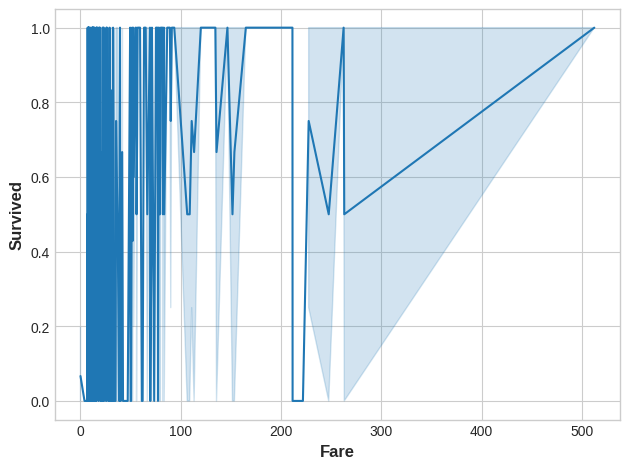

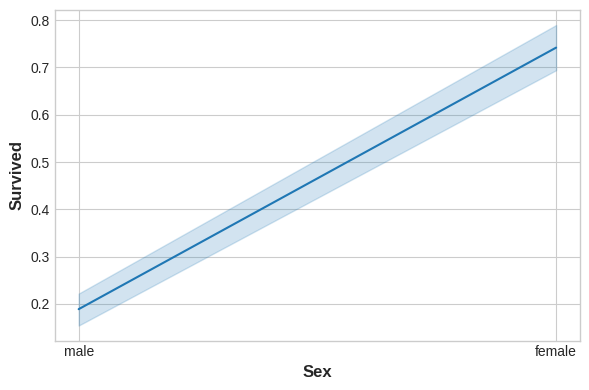

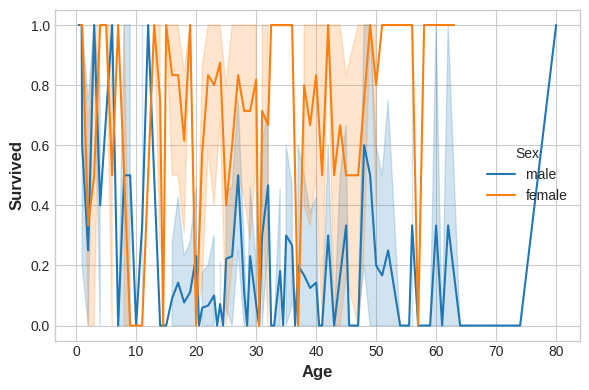

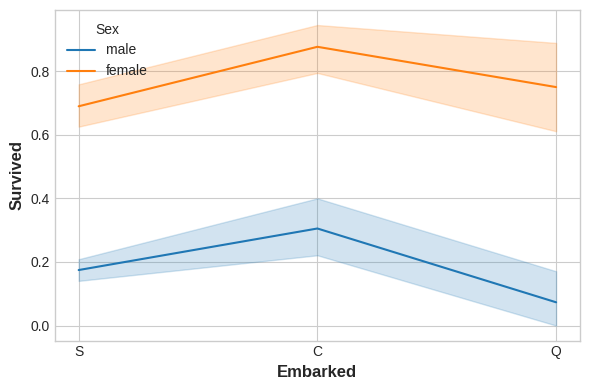

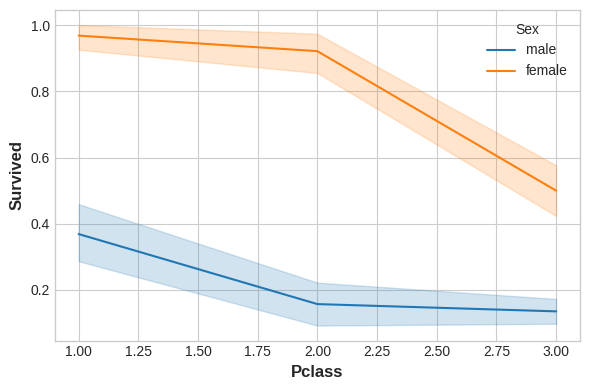

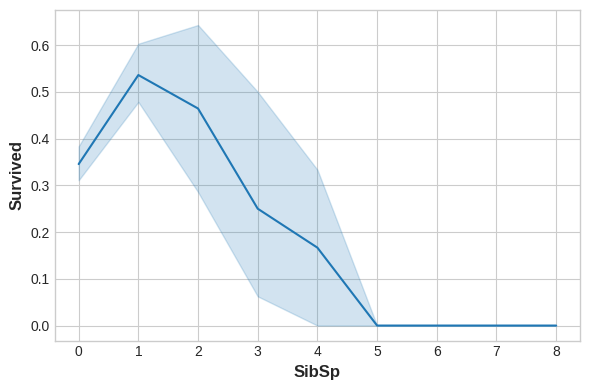

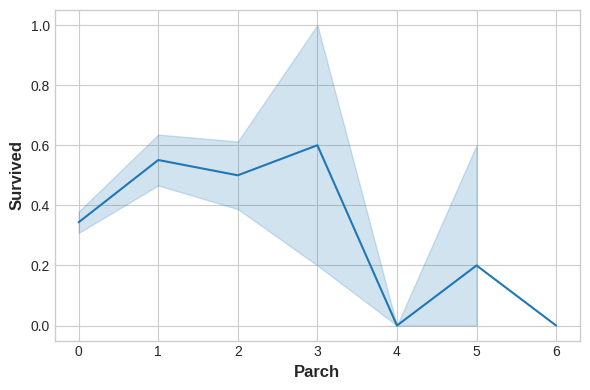

In [174]:
def graphical_hypothesis():
    data_path = Path("../input/titanic/")
    df_train = pd.read_csv(data_path / "train.csv", index_col="PassengerId")
    sns.lineplot(data=df_train, x="Fare", y="Survived")
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_train, x="Sex", y="Survived")
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_train, x="Age", y="Survived", hue="Sex")
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_train, x="Embarked", y="Survived", hue="Sex")
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_train, x="Pclass", y="Survived", hue="Sex")
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_train, x="SibSp", y="Survived")
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_train, x="Parch", y="Survived")
graphical_hypothesis()

In [175]:
def compute_title(title):
    if title in ["Mr", "Miss", "Mrs", "Master"]:
        return title
    else:
        return "Rare"

def compute_pont(pont):
    if pont in ["C", "B", "D", "A"]:
        return "luxury"
    else:
        return "economy"

def compute_ticket_prefix(ticket):
    parts = ticket.replace('.', '').replace('/', '').split(' ')
    if len(parts) > 0 and not parts[0].isdigit():
        return parts[0]
    else:
        return "None"

def clean(df):
    # Extract the person's title from the name, as this data often reflects social status.
    df["Title"] = df["Name"].str.extract(r',\s*([^\.]+)\.')
    df["Title"] = df["Title"].apply(compute_title)

    # Extract the person's family name, as it can be used to enable groupings (feature engineering).
    df["Name"] = df["Name"].str.split(',').str[0]
 #   df["Namelength"] = df["Name"].apply(len)

    # Extract the cabin deck (first letter of the cabin), as some decks were closer to lifeboats.
    df["Pont"] = df["Cabin"].str[0]
    df["Pont"] = df["Pont"].apply(compute_pont)

    # Extract ticket prefix
    df["Ticket"] = df["Ticket"].apply(compute_ticket_prefix)
    
    # Group rare ticket under "other" denomination
    ticket_occurence = df.Ticket.value_counts()
    rare_ticket = ticket_occurence[ticket_occurence < 10].index
    df["Ticket"] = df["Ticket"].apply(lambda x: "Other" if x in rare_ticket else x)

    # Drop unnecessary columns
    df = df.drop(columns=["Cabin"])
    #df = df.drop(columns=["Name"])
    return df

In [176]:
nominal_features = ["Name", "Sex", "Ticket", "Pont"]
one_hot_features = ["Embarked"]
title_levels = ["None", "Mr", "Rare", "Master", "Miss", "Mrs"]
ordinal_levels = {
    "Title": title_levels
}

def encode(df, train_indexes, test_indexes):
    # Encode nominal categories
    for feature in nominal_features:
        df[feature] = df[feature].astype("category")
        if "None" not in df[feature].cat.categories:
            df[feature] = df[feature].cat.add_categories("None")

    # Encode ordinal categories
    for feature, levels in ordinal_levels.items():
        df[feature] = df[feature].astype(CategoricalDtype(levels, ordered=True))

    # Declare One hot encoder class
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

    # Avoid data leakage
    df_train = df.loc[train_indexes].copy()
    df_test = df.loc[test_indexes].copy()

    # Encode one hot categories
    for feature in one_hot_features:
        df_train_encoded = OH_encoder.fit_transform(df_train[[feature]])
        df_test_encoded = OH_encoder.transform(df_test[[feature]])

        # Rename columns
        cols_names = [f"{feature}_{cat}" for cat in OH_encoder.categories_[0]]

        # Assign the columns to the encoded dataframe
        df_train_encoded = pd.DataFrame(df_train_encoded, columns=cols_names, index=df_train.index)
        df_test_encoded = pd.DataFrame(df_test_encoded, columns=cols_names, index=df_test.index)

        df_train = pd.concat([df_train.drop(columns=[feature]), df_train_encoded], axis=1)
        df_test = pd.concat([df_test.drop(columns=[feature]), df_test_encoded], axis=1)
    df = pd.concat([df_train, df_test]).sort_index()
    return df

In [177]:
def impute(df, train_index, test_index):
    # List each type of feature
    numerical_feature = ["Age", "Fare"]
    categorical_feature = {
        "Embarked": "C"
    }

    # Seperate the dataset
    df_train = df.loc[train_index].copy()
    df_test = df.loc[test_index].copy()
    
    # Init simple imputer class (Median strategy will be done for numerical features)
    median_imputer = SimpleImputer(strategy="median")
    for feature in numerical_feature:
        df_train[feature] = median_imputer.fit_transform(df_train[[feature]])
        df_test[feature] = median_imputer.transform(df_test[[feature]])

    # Init simple imputer class (Constant strategy will be done for categorical features)
    for feature, constant in categorical_feature.items():
        constant_imputer = SimpleImputer(strategy="constant", fill_value=constant)
        df_train[feature] = constant_imputer.fit_transform(df_train[[feature]]).ravel()
        df_test[feature] = constant_imputer.transform(df_test[[feature]]).ravel()

    # Retrive the data set
    df = pd.concat([df_train, df_test]).sort_index()
    return df

In [178]:
df_train, df_test = load_data()

In [179]:
def score_dataset(X_org, y, model=XGBClassifier()):
    X = X_org.copy()
    for colname in X.select_dtypes(["category"]):
       X[colname] = X[colname].cat.codes
    score = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    score = score.mean()
    return score

In [180]:
X = df_train.copy()
y = X.pop("Survived")
baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} ACCURACY")

Baseline score: 0.80692 ACCURACY


In [181]:
def make_mi_score(X_org, y):
    X = X_org.copy()
    for feature in X.select_dtypes(['object', 'category']):
        X[feature], _ = X[feature].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_score = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_score = pd.Series(mi_score, name="Mutual Information score", index=X.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score

In [182]:
mi_score = make_mi_score(X, y)
mi_score

Name          0.892167
Title         0.186309
Sex           0.141701
Fare          0.128706
Pclass        0.056076
Embarked_C    0.035712
Pont          0.032712
Age           0.028640
SibSp         0.026088
Embarked_Q    0.019422
Embarked_S    0.018932
Parch         0.012261
Ticket        0.000000
Name: Mutual Information score, dtype: float64

In [183]:
def drop_uninformative(df, mi):
    return df.loc[:, mi > 0.0]

In [184]:
def mathematical_transformation(X_org):
    X = X_org.copy()
    X['Fare_log'] = np.sqrt(X['Fare'])
    return X

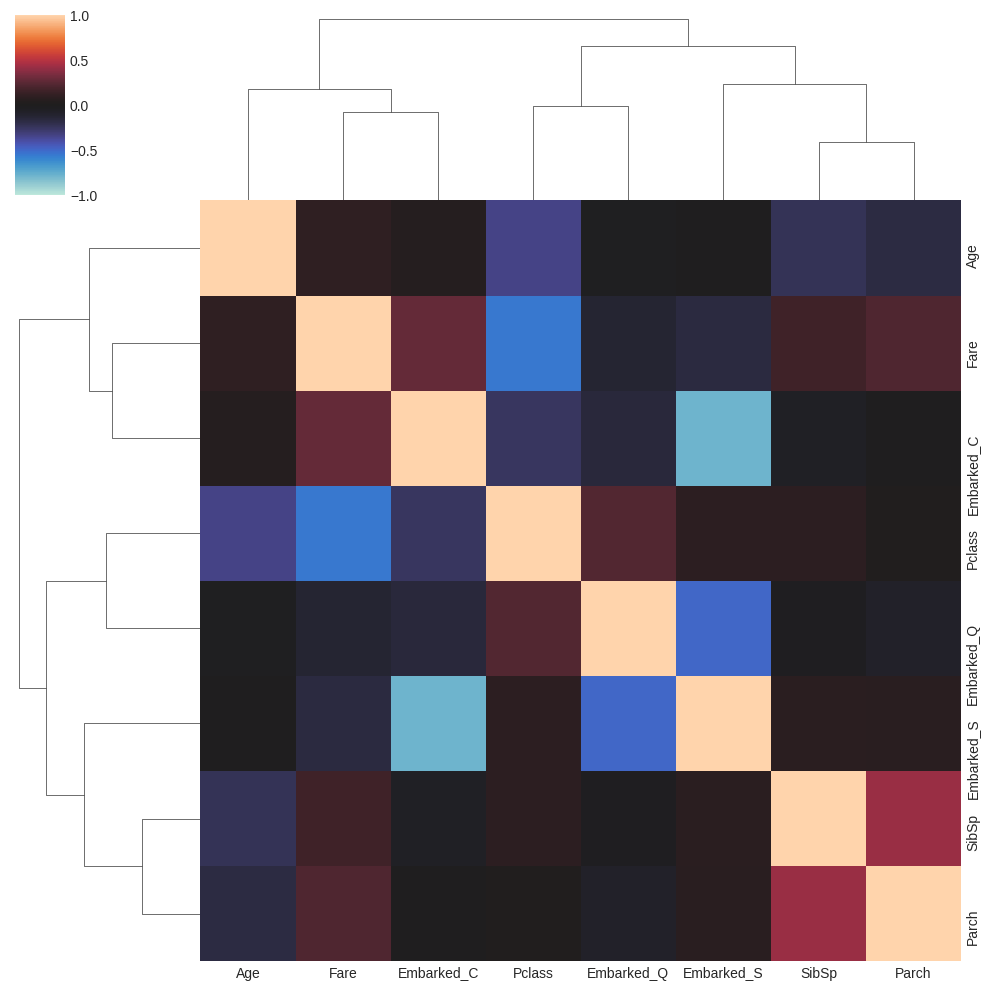

In [185]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )
corrplot(X, annot=None)

In [186]:
class CrossFoldEncoder:
    def __init__(self, _encoder, **kwargs):
        self.encoder = _encoder
        self.kwargs = kwargs
        self.cv = KFold(n_splits=5)

    def fit_transform(self, X, y, _cols):
        self.fitted_encoders = []
        self.cols = _cols
        X_encoded = []
        for idx_train, idx_encode in self.cv.split(X):
            fitted_encoder = self.encoder(cols=_cols, **self.kwargs)
            fitted_encoder.fit(
                X.iloc[idx_train, :], y.iloc[idx_train]
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_encode])[_cols])
            self.fitted_encoders.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded).sort_index()
        X_encoded.columns = [name + '_encoded' for name in X_encoded.columns]
        return X_encoded

    def transform(self, X):
        from functools import reduce
        X_encoded_list = []
        for encoders in self.fitted_encoders:
            X_encoded = encoders.transform(X)
            X_encoded_list.append(X_encoded[self.cols])
        X_encoded_final = reduce(lambda x, y: x.add(y, fill_value=0), X_encoded_list) / len(X_encoded_list)
        X_encoded_final.columns = [name + '_encoded' for name in X_encoded_final.columns]
        return X_encoded_final

In [187]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

In [188]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("Survived")
    mi_scores = make_mi_score(X, y)
    
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("Survived")
        X = pd.concat([X, X_test])

    drop_uninformative(X, mi_scores)
    X = mathematical_transformation(X)
    X = label_encode(X)

    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, ["Name"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X

df_train, df_test = load_data()
X_train = create_features(df_train)
print(X_train.info())
y_train = df_train.loc[:, "Survived"]

score_dataset(X_train, y_train)

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        891 non-null    int64  
 1   Name          891 non-null    int16  
 2   Sex           891 non-null    int8   
 3   Age           891 non-null    float64
 4   SibSp         891 non-null    int64  
 5   Parch         891 non-null    int64  
 6   Ticket        891 non-null    int8   
 7   Fare          891 non-null    float64
 8   Title         891 non-null    int8   
 9   Pont          891 non-null    int8   
 10  Embarked_C    891 non-null    float64
 11  Embarked_Q    891 non-null    float64
 12  Embarked_S    891 non-null    float64
 13  Fare_log      891 non-null    float64
 14  Name_encoded  891 non-null    float64
dtypes: float64(7), int16(1), int64(3), int8(4)
memory usage: 81.8 KB
None


0.8181846713953927

In [189]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "Survived"]

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBClassifier(**xgb_params)
print(X_train.info())
score_dataset(X_train, y_train, xgb)

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        891 non-null    int64  
 1   Name          891 non-null    int16  
 2   Sex           891 non-null    int8   
 3   Age           891 non-null    float64
 4   SibSp         891 non-null    int64  
 5   Parch         891 non-null    int64  
 6   Ticket        891 non-null    int8   
 7   Fare          891 non-null    float64
 8   Title         891 non-null    int8   
 9   Pont          891 non-null    int8   
 10  Embarked_C    891 non-null    float64
 11  Embarked_Q    891 non-null    float64
 12  Embarked_S    891 non-null    float64
 13  Fare_log      891 non-null    float64
 14  Name_encoded  891 non-null    float64
dtypes: float64(7), int16(1), int64(3), int8(4)
memory usage: 81.8 KB
None


0.8305191136777352

In [190]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "Survived"]

xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)

predictions = xgb.predict(X_test)

output = pd.DataFrame({'PassengerId': X_test.index, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
